In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# D3 Уравнение Пуассона

Решим сперва для теста уравнение Пуассона в прямоугольнике с граничными условиями первого рода.

In [12]:
x_min = -1.
x_max = 1.
nx = 100
y_min = -1.
y_max = 1.
ny = 100

In [13]:
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xg, yg = np.meshgrid(x,y)
f=1 - (xg**2 + yg**2)

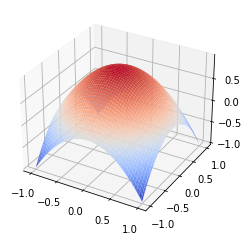

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, f, cmap=cm.coolwarm)
plt.show()

Согласно схемы
$$
\frac{\partial^2}{\partial x^2}u \rightarrow \dfrac{\dfrac{u_{i+1,j}-u_{i,j}}{x_{i+1,j}-x_{i,j}}-\dfrac{u_{i,j}-u_{i-1,j}}{x_{i,j}-x_{i-1,j}}}{\dfrac{x_{i+1,j}-x_{i-1,j}}{2}} = \dfrac{\dfrac{u_{i+1,j}-u_{i,j}}{dx_{i+1,j}}-\dfrac{u_{i,j}-u_{i-1,j}}{dx_{i,j}}}{\dfrac{dx_{i+1,j}+dx_{i,j}}{2}}
$$
Аналогично для y. Пока оставим произвольный шаг.
Уравнение Пуассона:
$$
\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2} = f(x,y)
$$
На каждой итерации будем удовлетворять его для $x_{i,j}\rightarrow x_{i,j}^{k+1}$, $x_{i\pm 1,j\pm 1}\rightarrow x_{i\pm 1,j\pm 1}^{k}$, т.е. расчитывать $k+1$ шаг. Потом восстанавливать в нем граничные условия и повторять.

$$
\frac{\partial^2}{\partial x^2}u \rightarrow -2\dfrac{\tfrac{1}{dx_{i+1,j}}+\tfrac{1}{dx_{i,j}}}{dx_{i+1,j}+dx_{i,j}}\cdot u_{i,j} + 2\dfrac{\dfrac{u_{i+1,j}}{dx_{i+1,j}}+\dfrac{u_{i-1,j}}{dx_{i,j}}}{dx_{i+1,j}+dx_{i,j}}
$$
Тогда:
$$
u_{i,j}^{k+1} = \left[\dfrac{1}{dx_{i+1,j}\cdot dx_{i,j}}+ \dfrac{1}{dy_{i,j+1}\cdot dy_{i,j}}  \right]^{-1}\left\{  
\dfrac{\dfrac{u_{i+1,j}}{dx_{i+1,j}}+\dfrac{u_{i-1,j}}{dx_{i,j}}}{dx_{i+1,j}+dx_{i,j}} +
\dfrac{\dfrac{u_{i,j+1}}{dy_{i,j+1}}+\dfrac{u_{i,j-1}}{dy_{i,j}}}{dy_{i,j+1}+dy_{i,j}}
- \dfrac{1}{2}f(x_{i,j},y_{i,j})
\right\},\quad i,j\in \overline{1, n-2}
$$

In [15]:
u = np.zeros(xg.shape)

In [16]:
dx = xg[1:-1,1:] - xg[1:-1,:-1]  # use dx[:, 1:] for dx_i+1 and dx[:, :-1] for dx_i
dy = yg[1:,1:-1] - yg[:-1,1:-1]  # use dy[1:, :] for dy_i+1 and dy[:-1, :] for dy_i
dxp = dx[:,1:]
dxm = dx[:,:-1]
dyp = dy[1:,:]
dym = dy[:-1,:]
fij = f[1:-1,1:-1]

In [17]:
# step
u_ip_j = u[1:-1,2:]
u_im_j = u[1:-1,:-2]
u_i_jp = u[2:,1:-1]
u_i_jm = u[:-2,1:-1]

u_kp = 1/(1/dxp/dxm + 1/dyp/dym) * ( (u_ip_j/dxp + u_im_j/dxm) / (dxp+dxm) + 
                                     (u_i_jp/dyp + u_i_jm/dym) / (dyp+dym) -
                                     1/2*fij )

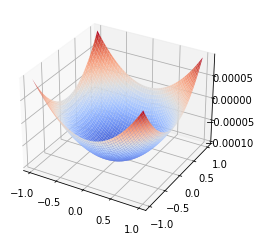

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg[1:-1,1:-1], yg[1:-1,1:-1], u_kp, cmap=cm.coolwarm)
plt.show()

In [19]:
u[1:-1,1:-1] = u_kp

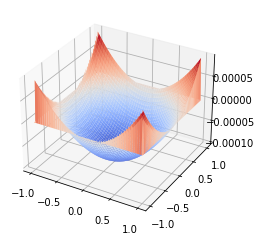

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, u, cmap=cm.coolwarm)
plt.show()

Окей, тесты сделаны, теперь решим итерационно:

In [21]:
def solve(xg, yg, f, steps=100):
    u = np.zeros(xg.shape)

    dx = xg[1:-1,1:] - xg[1:-1,:-1]  # use dx[:, 1:] for dx_i+1 and dx[:, :-1] for dx_i
    dy = yg[1:,1:-1] - yg[:-1,1:-1]  # use dy[1:, :] for dy_i+1 and dy[:-1, :] for dy_i
    dxp = dx[:,1:]
    dxm = dx[:,:-1]
    dyp = dy[1:,:]
    dym = dy[:-1,:]
    fij = f[1:-1,1:-1]

    for i in range(steps):
        u_ip_j = u[1:-1,2:]
        u_im_j = u[1:-1,:-2]
        u_i_jp = u[2:,1:-1]
        u_i_jm = u[:-2,1:-1]

        u_kp = 1/(1/dxp/dxm + 1/dyp/dym) * ( (u_ip_j/dxp + u_im_j/dxm) / (dxp+dxm) + 
                                             (u_i_jp/dyp + u_i_jm/dym) / (dyp+dym) -
                                             1/2*fij )
        u[1:-1,1:-1] = u_kp
    
    return np.copy(u)

In [22]:
sol = []
ss = [1, 10, 1000, 10000, 100000]
for s in ss:
    sol.append(solve(xg, yg, f, steps=s))

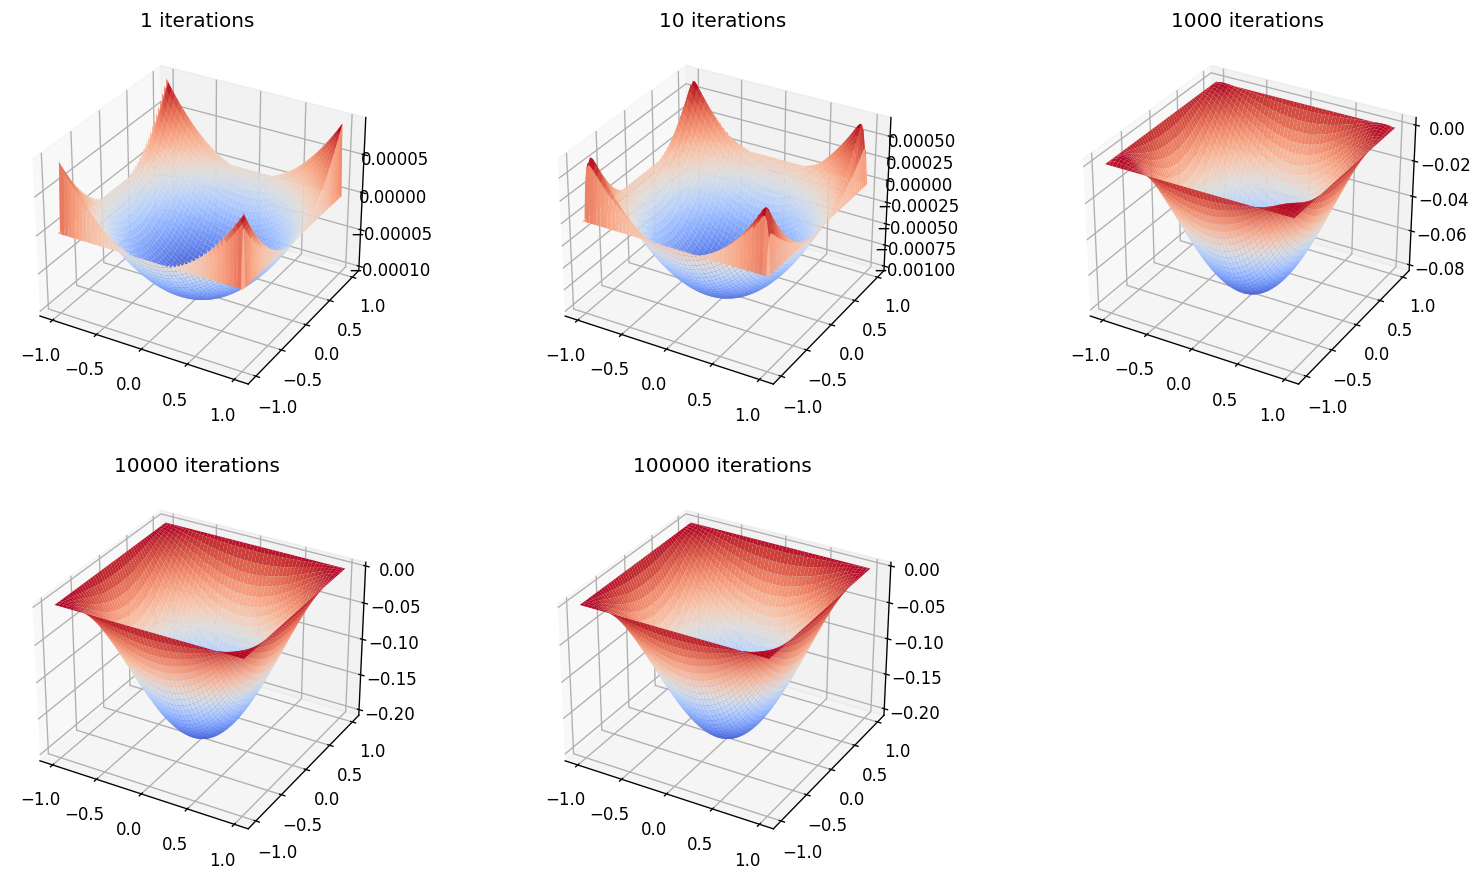

In [23]:
fig = plt.figure(figsize=(16, 9), dpi=120)
for i in range(1,6):
    ax = fig.add_subplot(2,3,i, projection='3d')
    ax.plot_surface(xg, yg, sol[i-1], cmap=cm.coolwarm)
    ax.set_title("{} iterations".format(ss[i-1]))
plt.show()

In [24]:
print("Max absolute difference between {} and {} iterations is {}".format(ss[-1],ss[-2],np.abs(sol[-1]-sol[-2]).max()))

Max absolute difference between 100000 and 10000 iterations is 0.0013263230991078234


Теперь можно попробовать решить задачу в круге и произвольной области. Сделаем это с помощью ее растеризации и маски, запрещающей изменять значения функции вне области.

In [25]:
x_min = -1.
x_max = 1.
nx = 100
y_min = -1.
y_max = 1.
ny = 100

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xg, yg = np.meshgrid(x,y)
f=1 - (xg**2 + yg**2)

Mask = np.array((xg**2 + yg**2) < 1.)[1:-1,1:-1]

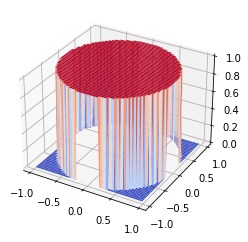

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg[1:-1,1:-1], yg[1:-1,1:-1], Mask, cmap=cm.coolwarm)
plt.show()

In [117]:
def solve_masked(xg, yg, f, Mask, u0=0, steps=100):
    if type(u0) == int:
        u0 = np.zeros(xg.shape)
    u = np.copy(u0)

    dx = xg[1:-1,1:] - xg[1:-1,:-1]  # use dx[:, 1:] for dx_i+1 and dx[:, :-1] for dx_i
    dy = yg[1:,1:-1] - yg[:-1,1:-1]  # use dy[1:, :] for dy_i+1 and dy[:-1, :] for dy_i
    dxp = dx[:,1:][Mask]
    dxm = dx[:,:-1][Mask]
    dyp = dy[1:,:][Mask]
    dym = dy[:-1,:][Mask]
    fij = f[1:-1,1:-1][Mask]

    for i in range(steps):
        u_ip_j = u[1:-1,2:][Mask]
        u_im_j = u[1:-1,:-2][Mask]
        u_i_jp = u[2:,1:-1][Mask]
        u_i_jm = u[:-2,1:-1][Mask]

        u_kp = 1/(1/dxp/dxm + 1/dyp/dym) * ( (u_ip_j/dxp + u_im_j/dxm) / (dxp+dxm) + 
                                             (u_i_jp/dyp + u_i_jm/dym) / (dyp+dym) -
                                             1/2*fij )
        u[1:-1,1:-1][Mask] = u_kp
    
    return np.copy(u)

In [118]:
solc = solve_masked(xg, yg, f, Mask, steps=30000)

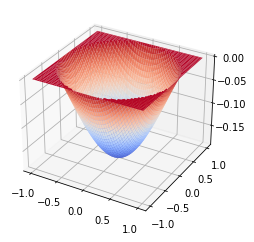

In [119]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, solc, cmap=cm.coolwarm)
plt.show()

Научимся задавать граничные условия. Для этого достаточно на границе маски определить начальную u.

Допустим, хочется что-то типа синуса вдоль границы. Зададим его везде, а потом занулим в круге, чтобы не мешать.

In [120]:
u0 = 0.05*np.cos(4*np.arctan2(yg, xg))
u0[1:-1,1:-1][Mask] = 0

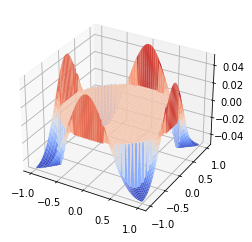

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, u0, cmap=cm.coolwarm)
plt.show()

In [122]:
solc2 = solve_masked(xg, yg, f, Mask, u0=u0, steps=10000)
solc2[1:-1,1:-1][Mask != True] = 0
solc2[:1, :] = 0
solc2[-1:, :] = 0
solc2[:, :1] = 0
solc2[:, -1:] = 0

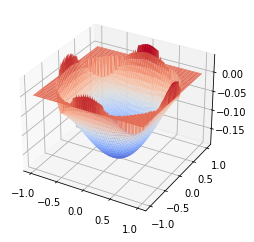

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, solc2, cmap=cm.coolwarm)
plt.show()

Напоследок, нарисуем еще кружочек внутри, чтобы область была многосвязной и положим на его грранице функции нулем:

In [38]:
Mask2 = np.logical_and(np.array(((xg**2 + yg**2) < 1.)), np.array((0.3-xg)**2+(0.2-yg)**2 > 0.05))[1:-1,1:-1]

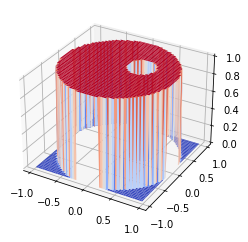

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg[1:-1,1:-1], yg[1:-1,1:-1], Mask2, cmap=cm.coolwarm)
plt.show()

In [115]:
u0 = 0.05*np.cos(4*np.arctan2(yg, xg))
u0[1:-1,1:-1][Mask] = 0

In [112]:
solc3 = solve_masked(xg, yg, f, Mask2, u0=u0, steps=10000)
solc3[1:-1,1:-1][Mask2 != True] = 0
solc3[:1, :] = 0
solc3[-1:, :] = 0
solc3[:, :1] = 0
solc3[:, -1:] = 0

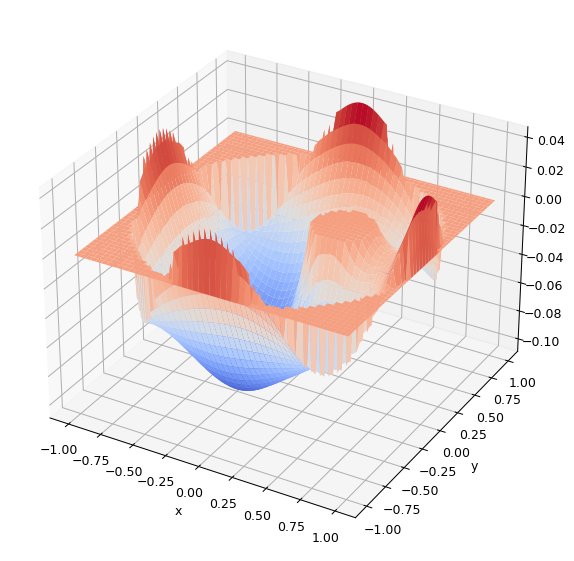

In [113]:
fig = plt.figure(figsize=(8,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, solc3, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

В общем, задача выполнена, что-то решается, области задаются. Код позволяет вычислять в том числе на нерегулярных, но прямоугольных сетках. Так что можно задать кружочки более умным способом, если ккому-то этого захочется.

# D4 Уравнение параболлического типа

Решение прошлой задачи легко обобщается для решения уравнения типа:
$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} +f(x,y)
$$
Недостаточно просто сохранять в решение каждый шаг, т.к. мы пользовались неявной схемой. Вернемся к явной. Это было ошибкой, осталось за кадром. В итогее пользовался полунеявной хрен пойми какой схемой (было удобно обобщаать из предыдущего пункта):
$$
\dfrac{u_{i,j}^{k+1} - u_{i,j}^{k}}{dt} = \dfrac{\dfrac{u_{i+1,j}^{k}-u_{i,j}^{k+1}}{dx_{i+1,j}}-\dfrac{u_{i,j}^{k+1}-u_{i-1,j}^{k}}{dx_{i,j}}}{\dfrac{dx_{i+1,j}+dx_{i,j}}{2}} + \dfrac{\dfrac{u_{i,j+1}^{k}-u_{i,j}^{k+1}}{dy_{i,j+1}}-\dfrac{u_{i,j}^{k+1}-u_{i-1,j}^{k}}{dy_{i,j}}}{\dfrac{dy_{i,j+1}+dy_{i,j}}{2}} + f_{i,j}
$$

In [253]:
def solve_masked_parabolic(xg, yg, f, dt, Mask, u0=0, steps=100):
    if type(u0) == int:
        u0 = np.zeros(xg.shape)
    u = np.copy(u0)

    dx = xg[1:-1,1:] - xg[1:-1,:-1]  # use dx[:, 1:] for dx_i+1 and dx[:, :-1] for dx_i
    dy = yg[1:,1:-1] - yg[:-1,1:-1]  # use dy[1:, :] for dy_i+1 and dy[:-1, :] for dy_i
    dxp = dx[:,1:][Mask]
    dxm = dx[:,:-1][Mask]
    dyp = dy[1:,:][Mask]
    dym = dy[:-1,:][Mask]
    fij = f[1:-1,1:-1][Mask]

    sol = []
    sol.append(np.copy(u))
    
    for i in range(steps):
        
        u_ip_j = u[1:-1,2:][Mask]
        u_im_j = u[1:-1,:-2][Mask]
        u_i_jp = u[2:,1:-1][Mask]
        u_i_jm = u[:-2,1:-1][Mask]
        u_i_j = u[1:-1,1:-1][Mask]

        u_kp = 1/(1/dxp/dxm + 1/dyp/dym + 1/dt) * ( (u_ip_j/dxp + u_im_j/dxm) / (dxp+dxm) + 
                                             (u_i_jp/dyp + u_i_jm/dym) / (dyp+dym) +
                                             1/2*fij - u_i_j/dt)
        u[1:-1,1:-1][Mask] = u_kp
        sol.append(np.copy(u));
    
    return np.array(sol)

In [274]:
solc4 = solve_masked_parabolic(xg, yg, -f, 0.1, Mask2, steps=2000)

In [275]:
t = np.arange(solc4.shape[0])*0.1
xt_x, xt_t = np.meshgrid(x, t)

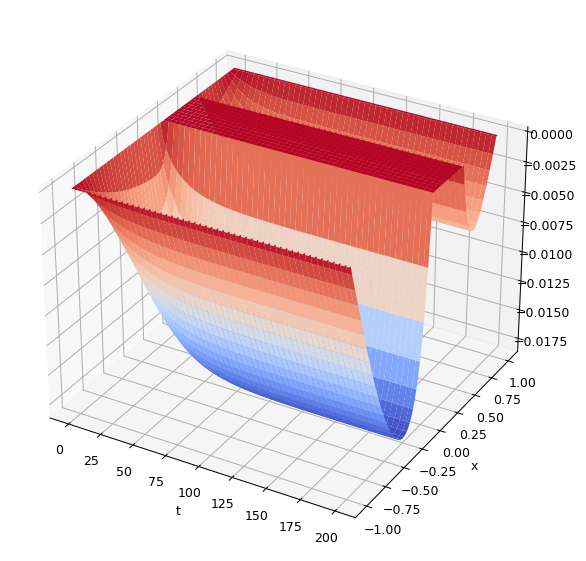

In [276]:
fig = plt.figure(figsize=(8,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xt_t, xt_x, solc4[:, 60, :], cmap=cm.coolwarm)
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.show()

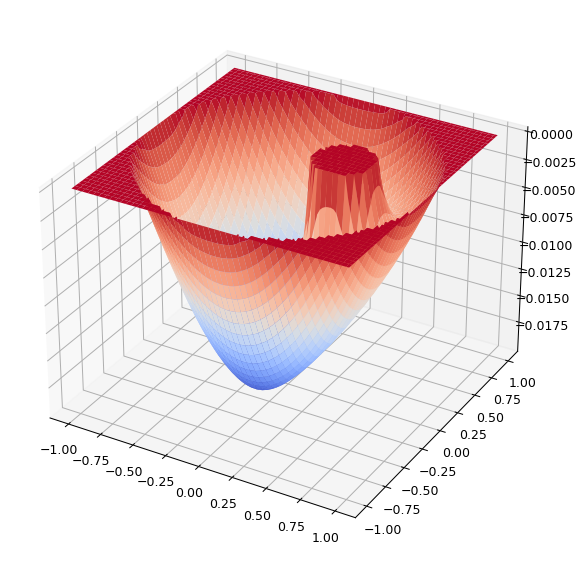

In [277]:
fig = plt.figure(figsize=(8,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, solc4[1000, :, :], cmap=cm.coolwarm)
plt.show()

В общем задача сходится к решению уравнения Пуассона, как и написано везде.